In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from augur.utils import json_to_tree
import json
import math

# Grabbing accumulated mutations for each variant

In [2]:
# BA.2 shows up as "NODE_0000260" when it is not a child node
END_NODE = "NODE_0000260"

#grab lineage of tip node
def find_lineage(tree, child_node, rows_for_tsv):
    gene_muts = {}
    node_path = tree.get_path(child_node)
    i = len(node_path) - 1
    while (i >= 0 and END_NODE not in node_path[i].name):
        # none children node names show up weirdly...
        # are parent node names consistent for each run?
        # print(node_path[i].name)
        i = i - 1
        gene_muts = format_string(node_path[i].branch_attrs['mutations'],'nuc', gene_muts)
    #append variant name, mutation, and region to list
    for k in gene_muts.keys():
        for j in range(len(gene_muts[k])):
            temp_dict = gene_muts[k]
            mut =  str(temp_dict[j]) + '_' + str(k)
            rows_for_tsv.append({'variant': child_node.name, 'mutation': mut})

#put all the same gene mutations in the same list
def format_string(dict, key, gene_muts):
    for k in dict.keys():
        if (str(k) != key):
            if k not in gene_muts.keys():
                gene_muts[k] = []
            for j in range(len(dict[k])):
                temp_dict = dict[k]
                gene_muts[k].append(temp_dict[j])
    return gene_muts

if __name__ == '__main__':
    #read in tree
    with open(f'../mutations-by-variant/pango_lineages.json', 'r') as f:
        tree_json = json.load(f)
    #put tree in Bio.Phylo format
    tree = json_to_tree(tree_json)
    #create list of dictionaries for dataframe
    rows_for_tsv = []
    for tip in tree.find_clades(terminal=True):
        #append new row for every mutation in every child node
        find_lineage(tree, tip, rows_for_tsv)
    #make pandas dataframe from list of dicts
    accumulated_mutations = pd.DataFrame(rows_for_tsv)

In [3]:
#viewing accumulated mutations df
#accumulated_mutations = pd.read_csv("accumulated_mutations_output.tsv", sep="\t")
accumulated_mutations

,variant,mutation
0,XA,S3L_E
1,XA,S6L_E
2,XA,T9I_E
3,XA,T11M_E
4,XA,L18F_E
...,...,...
403550,CK.2.1.1,D3N_M
403551,CK.2.1.1,L61D_ORF6
403552,CK.2.1.1,D61L_ORF6
403553,CK.2.1.1,T842I_ORF1a


# Assigning Mutational GAs to each variant

In [4]:
import jax.numpy as jnp
import numpy as np
import evofr as ef
from evofr.models.mutational_fitness_mlr import MutationalFitnessMLR, MutationalFitnessSequenceCounts

In [5]:
# Getting data
raw_seq = pd.read_csv("../../sars2-epistasis-modeling/count-data/pango_location-variant-sequence-counts.tsv", sep="\t")
raw_seq = raw_seq[~raw_seq.variant.str.startswith("X")]
raw_muts = accumulated_mutations
variant_frequencies = MutationalFitnessSequenceCounts(raw_seq, raw_muts)

In [6]:
# Defining model
mlr = MutationalFitnessMLR(tau=4.2)
# Defining inference method
inference_method = ef.InferMAP(iters=100_000, lr=4e-4)
# Fitting model
posterior = inference_method.fit(mlr, variant_frequencies)
samples = posterior.samples

In [7]:
# defining the growth advantages
mut_ga = pd.DataFrame(
    ef.posterior.get_growth_advantage(samples, posterior.data, ps=[0.8], name="USA", rel_to="BA.2")
)

In [8]:
#viewing mutational ga df
mut_ga

,location,variant,median_ga,ga_upper_80,ga_lower_80
0,USA,B.1.1.529,1.361368,1.361368,1.361368
1,USA,BA.1,0.647601,0.647601,0.647601
2,USA,BA.1.1,0.67734087,0.67734087,0.67734087
3,USA,BA.1.1.1,0.67577994,0.67577994,0.67577994
4,USA,BA.1.1.10,0.7585253,0.7585253,0.7585253
...,...,...,...,...,...
173,USA,BQ.1.14,2.595908,2.595908,2.595908
174,USA,BQ.1.2,2.595908,2.595908,2.595908
175,USA,BQ.1.3,2.5959108,2.5959108,2.5959108
176,USA,BQ.1.6,2.5959108,2.5959108,2.5959108


# Assigning individual fitnesses to each mutation

In [9]:
# Grabbing fitness for each mutation, in sorted order
def mutations(samples, data):
    rows_for_tsv = []
    delta = jnp.median(samples["raw_delta"], axis=0)
    idx = (-delta).argsort()[:len(delta)]
    for i in idx:
        array = delta[i]
        rows_for_tsv.append({'mutation':data.mut_names[i], 'fitness_effect':array})
    return rows_for_tsv
table = mutations(samples, variant_frequencies)
mutations_table = pd.DataFrame(table)

In [10]:
# creating summary table with variant name, variant ga, mutation, mutation fitness
final_table = pd.merge(mut_ga, raw_muts, on="variant")
final_table = pd.merge(final_table, mutations_table, on="mutation")
final_table = final_table.drop(final_table.columns[0], axis=1)
final_table = final_table.drop(final_table.columns[2], axis=1)
final_table = final_table.drop(final_table.columns[2], axis=1)
# renaming the table
mutations_summary = final_table

In [11]:
# viewing table of mutation fitnesses
mutations_summary

,variant,median_ga,mutation,fitness_effect
0,BA.1,0.647601,D3G_M,0.26506385
1,BA.1.1,0.67734087,D3G_M,0.26506385
2,BA.1.1.1,0.67577994,D3G_M,0.26506385
3,BA.1.1.10,0.7585253,D3G_M,0.26506385
4,BA.1.1.14,0.68747836,D3G_M,0.26506385
...,...,...,...,...
6046,BQ.1.6,2.5959108,Y264H_ORF1b,-0.32932904
6047,BQ.1.1,2.7864332,N1191S_ORF1b,-0.028118502
6048,BQ.1.1.3,2.7864332,N1191S_ORF1b,-0.028118502
6049,BQ.1.1.4,2.7864332,N1191S_ORF1b,-0.028118502


# Assigning innovation GA to variants

In [12]:
# Getting data
raw_seq = pd.read_csv("../count-data/pango_location-variant-sequence-counts.tsv", sep="\t")
# raw_variant_parents is missing a row for BA.2, so append one
raw_variant_parents = pd.concat((pd.read_csv("../count-data/pango_variant-relationships.tsv", sep="\t"),
                                pd.DataFrame({"variant": ["BA.2"], "parent": ["base"]}))).reset_index(drop=True)
variant_frequencies = ef.InnovationSequenceCounts(raw_seq, raw_variant_parents, pivot="BA.2")

In [13]:
# Defining model
mlr = ef.InnovationMLR(tau=4.2)
# Defining inference method
inference_method = ef.InferFullRank(iters=50_000, lr=4e-3, num_samples=100)
# Fitting model
posterior = inference_method.fit(mlr, variant_frequencies)
samples = posterior.samples

In [14]:
innovation_ga = pd.DataFrame(
    ef.posterior.get_growth_advantage(samples, posterior.data, ps=[0.8], name="USA", rel_to="BA.2")
)

In [15]:
#viewing innovation ga df
innovation_ga

,location,variant,median_ga,ga_upper_80,ga_lower_80
0,USA,B.1.1.529,1.6010664,1.6118482,1.5900564
1,USA,BA.1,0.6463461,0.6486746,0.6445043
2,USA,BA.1.1,0.67117923,0.67293787,0.6695072
3,USA,BA.1.1.1,0.67707324,0.69769114,0.659423
4,USA,BA.1.1.10,0.7396455,0.7540303,0.7293008
...,...,...,...,...,...
179,USA,XAZ,1.8764315,1.8844258,1.8708602
180,USA,XBB.1,2.5197105,2.5291803,2.513054
181,USA,XE,1.0530934,1.0607386,1.0462605
182,USA,XZ,1.1032207,1.1123761,1.0958667


# Comparing Innovation and Mutational Growth Advantages

In [16]:
# resolving weird formatting issues btwn csv and loading pandas df??
mut_ga.to_csv('mut_ga.tsv', sep="\t")
innovation_ga.to_csv('innov_ga.tsv', sep="\t")

In [17]:
# loading in datasets
parent_variant_relationships = pd.read_csv("../count-data/pango_variant-relationships.tsv", sep="\t").set_index("variant")
mut_ga = pd.read_csv("mut_ga.tsv", sep="\t")
innovation_ga = pd.read_csv("innov_ga.tsv", sep="\t")

In [18]:
# Prep to merge
def clean_and_merge(innovation_ga, mut_ga, parent_variant_relationships):
    innovation_ga = (innovation_ga
                     .rename(columns={"median_ga": "innov-ga"})
                     [["variant", "innov-ga"]])

    mut_ga = (mut_ga
              .rename(columns={"median_ga": "mut-ga"})
              [["variant", "mut-ga"]])

    ga_df = innovation_ga.merge(mut_ga, how="right").set_index("variant")
    ga_df["mut-ga"] = ga_df["mut-ga"] / ga_df.loc["BA.2.1"]["mut-ga"] # Scale GA by BA.2.1

    # Add parents
    def _get_parent(row):
        variant = row.name
        if variant in parent_variant_relationships.index:
            return parent_variant_relationships.loc[variant]
        return "NAN"

    ga_df["parent"] = ga_df.apply(_get_parent, axis=1)
    return ga_df

In [19]:
ga_df = clean_and_merge(innovation_ga, mut_ga, parent_variant_relationships)

In [20]:
# Look for parent for mut-parent-ga
def add_deltas(row, prefix):
    # Give up if parent not found
    if row.parent not in ga_df.index:
        return pd.Series([np.nan, np.nan],
                         index=[prefix + "-parent-ga", prefix + "-pc-ratio"])
    # Get child growth advantage
    parent_row = ga_df.loc[row.parent]
    
    # Return parent ga and ratio
    return pd.Series([parent_row[prefix + "-ga"],  row[prefix + "-ga"] / parent_row[prefix + "-ga"]],
                         index=[prefix + "-parent-ga", prefix + "-pc-ratio"])
    
ga_df[["mut-parent-ga", "mut-pc-ratio"]] = ga_df.apply(add_deltas, prefix="mut", axis=1)
ga_df[["innov-parent-ga", "innov-pc-ratio"]] = ga_df.apply(add_deltas, prefix="innov", axis=1)

In [21]:
def is_outlier_IQR(data, col, scale=1.5):
    """
    Find wheter outliers in column col from dataframe data
    Uses IQR rule based on normal approximation.
    """

    Q3 = np.quantile(data[col], 0.75)
    Q1 = np.quantile(data[col], 0.25)
    IQR = Q3 - Q1
    lower_bound = Q1 - scale * IQR
    upper_bound = Q3 + scale * IQR
    return (data[col] < lower_bound) | (data[col] > upper_bound)

    
ga_df["innov-mut-ratio"] = ga_df["innov-ga"] / ga_df["mut-ga"]
ga_df["log-innov-mut-ratio"] = np.log(ga_df["innov-ga"] / ga_df["mut-ga"])
ga_df["outlier"] = is_outlier_IQR(ga_df, "log-innov-mut-ratio") # log-innov-mut-ratio ~ Normal()

In [22]:
# viewing ga_df
ga_df

,innov-ga,mut-ga,parent,mut-parent-ga,mut-pc-ratio,innov-parent-ga,innov-pc-ratio,innov-mut-ratio,log-innov-mut-ratio,outlier
variant,,,,,,,,,,
B.1.1.529,1.601066,1.282535,BA.2,NaN,NaN,NaN,NaN,1.248361,0.221832,False
BA.1,0.646346,0.610100,BA.2,NaN,NaN,NaN,NaN,1.059410,0.057712,False
BA.1.1,0.671179,0.638118,BA.1,0.610100,1.045923,0.646346,1.038421,1.051811,0.050513,False
BA.1.1.1,0.677073,0.636647,BA.1.1,0.638118,0.997696,0.671179,1.008782,1.063498,0.061564,False
BA.1.1.10,0.739645,0.714601,BA.1.1,0.638118,1.119858,0.671179,1.102009,1.035047,0.034447,False
...,...,...,...,...,...,...,...,...,...,...
BQ.1.14,2.479692,2.445585,BQ.1,2.445585,1.000000,2.526308,0.981548,1.013946,0.013850,False
BQ.1.2,2.461062,2.445585,BQ.1,2.445585,1.000000,2.526308,0.974173,1.006328,0.006308,False
BQ.1.3,2.485927,2.445588,BQ.1,2.445585,1.000001,2.526308,0.984016,1.016495,0.016360,False


## Plotting mutational ga vs. innovation ga

Each datapoint is a variant. Red datapoints are variants in which the rato between innovation/mutational ga is considered an outlier. Therefore, red variants might indicate epistasis where blue datapoint variants would indicate no epistasis. 

Text(0, 0.5, 'Mutation GA')

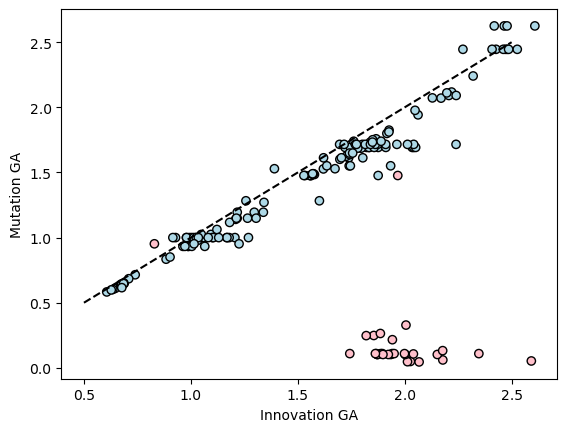

In [23]:
# Coloring by outlier
plt.scatter(ga_df["innov-ga"], ga_df["mut-ga"], 
            color=["pink" if value else "lightblue" for value in ga_df.outlier], 
            ec="k")
plt.plot([0.5, 2.5], [0.5, 2.5], color="k", linestyle="--")
plt.xlabel("Innovation GA")
plt.ylabel("Mutation GA")

# Looking at Outliers

In [24]:
# Defining outliers
outliers = ga_df[ga_df.outlier & (ga_df["mut-pc-ratio"] < 0.5)]

In [25]:
# Looking at outliers in bottom right with low ga
outliers

,innov-ga,mut-ga,parent,mut-parent-ga,mut-pc-ratio,innov-parent-ga,innov-pc-ratio,innov-mut-ratio,log-innov-mut-ratio,outlier
variant,,,,,,,,,,
BA.5.1.21,1.855334,0.248369,BA.5.1,1.692330,0.146762,1.793684,1.034371,7.470069,2.010904,True
BA.5.10.1,2.005854,0.328307,BA.5,1.692330,0.193997,1.781341,1.126036,6.109691,1.809876,True
BA.5.2.16,1.935031,0.102519,BA.5.2,1.715751,0.059752,1.873511,1.032837,18.874826,2.937829,True
BA.5.2.19,1.941598,0.109233,BA.5.2,1.715751,0.063665,1.873511,1.036342,17.774901,2.877787,True
BA.5.2.2,1.743165,0.109233,BA.5.2,1.715751,0.063665,1.873511,0.930427,15.958288,2.769978,True
BA.5.2.20,1.887846,0.109233,BA.5.2,1.715751,0.063665,1.873511,1.007651,17.282811,2.849712,True
BA.5.2.21,1.866808,0.109233,BA.5.2,1.715751,0.063665,1.873511,0.996423,17.090217,2.838506,True
BA.5.2.22,1.950439,0.109233,BA.5.2,1.715751,0.063665,1.873511,1.041061,17.855836,2.882330,True
BA.5.2.24,2.152393,0.102519,BA.5.2,1.715751,0.059752,1.873511,1.148855,20.995034,3.044286,True


# Verifying Outlier Mutational GA Assignments

Given that:

    relative_fitness_variant = sum(mutational_fitness for mutation in variant)
    mutational_ga_variant = exp(relative_fitness_variant * generation_time)
    generation_time is fixed at 4.2

The calculated_ga variable for each variant is assigned using the equation above. 

In [26]:
# compiling outlier summary table with indv fitnesses and mutational ga

# just looking at outliers for now
outlier_variants = ga_df[ga_df["outlier"]].index
# group by variants
grouped = mutations_summary.groupby('variant')
# final df
rows_for_tsv = []
for name, group in grouped:
    if name in outlier_variants:
        variant_dict = {}
        mutations = group['mutation']
        variant_dict['variant'] = name
        mut_ga = group['median_ga'].iloc[0]
        variant_dict['mut_ga'] = mut_ga
        cum_sum = 0
        for m in mutations:
            # grabbing the fitness effect  of each mutation
            fitness_effect = group.loc[group['mutation'] == m, 'fitness_effect'].iloc[0]
            variant_dict[m] = fitness_effect
            # summing up all mutation fitnesses
            cum_sum += fitness_effect
        # multiply by generation time and raise e to this number
        calculated_ga = math.exp(cum_sum * 4.2)
        variant_dict['calculated_ga'] = calculated_ga
        variant_dict['match'] = (mut_ga == calculated_ga)
        rows_for_tsv.append(variant_dict)
resulting_table = pd.DataFrame(rows_for_tsv)      

In [27]:
resulting_table

,variant,mut_ga,G446S_S,L3201F_ORF1a,T842I_ORF1a,L3027F_ORF1a,R1315C_ORF1b,T2163I_ORF1b,D61L_ORF6,T19I_S,...,A1312V_ORF1b,T2537I_ORF1b,K444T_S,Q556K_ORF1a,E136D_N,M1156I_ORF1b,L3829F_ORF1a,S10F_ORF9b,S50L_ORF9b,F490S_S
0,BA.2.75,0.051925015,0.08432963,0.014202826,-0.6249694,-0.24102327,0.6119087,0.5393136,-0.18012968,0.2343689,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BA.2.75.1,0.050065827,0.08432963,0.014202826,-0.6249694,-0.24102327,0.6119087,0.5393136,-0.18012968,0.2343689,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BA.2.75.2,0.0642575,0.08432963,0.014202826,-0.6249694,-0.24102327,0.6119087,0.5393136,-0.18012968,0.2343689,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BA.2.75.5,0.048186705,0.08432963,0.014202826,-0.6249694,-0.24102327,0.6119087,0.5393136,-0.18012968,0.2343689,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BA.2.9.2,1.0108103,NaN,0.014202826,-0.6249694,-0.24102327,0.6119087,0.5393136,-0.18012968,0.2343689,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,BA.4.1.9,1.5674098,NaN,NaN,-0.6249694,-0.24102327,0.6119087,0.5393136,-0.18012968,0.2343689,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,BA.5.1.21,0.26363552,NaN,NaN,-0.6249694,-0.24102327,0.6119087,0.5393136,-0.18012968,0.2343689,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,BA.5.10.1,0.3484869,NaN,NaN,-0.6249694,-0.24102327,0.6119087,0.5393136,-0.18012968,0.2343689,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,BA.5.2.16,0.10882067,NaN,NaN,-0.6249694,-0.24102327,0.6119087,0.5393136,-0.18012968,0.2343689,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,BA.5.2.19,0.11594676,NaN,NaN,-0.6249694,-0.24102327,0.6119087,0.5393136,-0.18012968,0.2343689,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
#aesthetic changes to the summary df

# moving mut_ga to end 
cols_at_end = ['calculated_ga', 'mut_ga', 'match']
resulting_table = resulting_table[[c for c in resulting_table if c not in cols_at_end] 
        + [c for c in cols_at_end if c in resulting_table]]
# concatenating innovation ga column info 
trimmed = ga_df[ga_df["outlier"]].drop(columns=['mut-ga','parent','mut-parent-ga','mut-pc-ratio','innov-parent-ga','innov-pc-ratio','innov-mut-ratio','log-innov-mut-ratio','outlier'])
merged = pd.merge(resulting_table, trimmed, on="variant", how="left")
resulting_table = merged

In [29]:
# viewing mutational fitnesses for outliers
resulting_table

,variant,G446S_S,L3201F_ORF1a,T842I_ORF1a,L3027F_ORF1a,R1315C_ORF1b,T2163I_ORF1b,D61L_ORF6,T19I_S,L24-_S,...,E136D_N,M1156I_ORF1b,L3829F_ORF1a,S10F_ORF9b,S50L_ORF9b,F490S_S,calculated_ga,mut_ga,match,innov-ga
0,BA.2.75,0.08432963,0.014202826,-0.6249694,-0.24102327,0.6119087,0.5393136,-0.18012968,0.2343689,-0.011357719,...,NaN,NaN,NaN,NaN,NaN,NaN,0.038142,0.051925015,False,2.026580
1,BA.2.75.1,0.08432963,0.014202826,-0.6249694,-0.24102327,0.6119087,0.5393136,-0.18012968,0.2343689,-0.011357719,...,NaN,NaN,NaN,NaN,NaN,NaN,0.036776,0.050065827,False,2.013056
2,BA.2.75.2,0.08432963,0.014202826,-0.6249694,-0.24102327,0.6119087,0.5393136,-0.18012968,0.2343689,-0.011357719,...,NaN,NaN,NaN,NaN,NaN,NaN,0.047201,0.0642575,False,2.178198
3,BA.2.75.5,0.08432963,0.014202826,-0.6249694,-0.24102327,0.6119087,0.5393136,-0.18012968,0.2343689,-0.011357719,...,NaN,NaN,NaN,NaN,NaN,NaN,0.035396,0.048186705,False,2.067359
4,BA.2.9.2,NaN,0.014202826,-0.6249694,-0.24102327,0.6119087,0.5393136,-0.18012968,0.2343689,-0.011357719,...,NaN,NaN,NaN,NaN,NaN,NaN,0.742496,1.0108103,False,0.829394
5,BA.4.1.9,NaN,NaN,-0.6249694,-0.24102327,0.6119087,0.5393136,-0.18012968,0.2343689,-0.011357719,...,NaN,NaN,NaN,NaN,NaN,NaN,1.151350,1.5674098,False,1.967557
6,BA.5.1.21,NaN,NaN,-0.6249694,-0.24102327,0.6119087,0.5393136,-0.18012968,0.2343689,-0.011357719,...,NaN,NaN,NaN,NaN,NaN,NaN,0.193655,0.26363552,False,1.855334
7,BA.5.10.1,NaN,NaN,-0.6249694,-0.24102327,0.6119087,0.5393136,-0.18012968,0.2343689,-0.011357719,...,NaN,NaN,NaN,NaN,NaN,NaN,0.255983,0.3484869,False,2.005854
8,BA.5.2.16,NaN,NaN,-0.6249694,-0.24102327,0.6119087,0.5393136,-0.18012968,0.2343689,-0.011357719,...,NaN,NaN,NaN,NaN,NaN,NaN,0.079935,0.10882067,False,1.935031
9,BA.5.2.19,NaN,NaN,-0.6249694,-0.24102327,0.6119087,0.5393136,-0.18012968,0.2343689,-0.011357719,...,NaN,NaN,NaN,NaN,NaN,NaN,0.085169,0.11594676,False,1.941598


In [31]:
# saving summary table to csv
resulting_table.to_csv('reformatted_table.tsv', sep='\t')

## Outstanding Questions

The calculated ga and assigned mutational ga should match for each variant. As seen above, none of them do. What is going on?